### This time we will use Context length and more features (see Bengio et al. 2003)

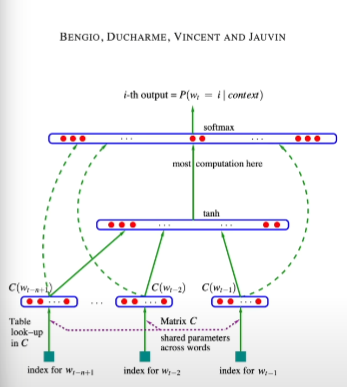

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
print(f"{len(words)} names loaded")

32033 names loaded


In [4]:
# build the vocabulary of characters and the mapping to integers
chars = sorted(list(set(''.join(words))))
stoi = { ch: i+1 for i, ch in enumerate(chars) }
stoi['.'] = 0
itos = { i: ch for ch, i in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
def build_dataset(words, block_size=3, log=False) -> tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []
 
    for w in words:
        if log:
            print(w)
        # initialize the context with dots
        context = [0] * block_size # padding the beginning of the sentence with dots
        for ch in w + '.': # padding the end of the sentence with a dot
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            if log:
                print(''.join([itos[i] for i in context]), '->', ch)
            context = context[1:] + [idx] # update the context for next iteration
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)        
    
    return X, Y

X, Y = build_dataset(words[:2], log=True)

emma
... -> e
..e -> m
.em -> m
emm -> a
mma -> .
olivia
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .


In [6]:
# size is examples x block_size
X, Y = build_dataset(words[:2], block_size=3)
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([12, 3]), torch.int64, torch.Size([12]), torch.int64)

In the paper they have 17000 words and cramp them into 30 dimensional spaces. We only have 27 characters so let's try to cramp them into 2 dimensional spaces.

In [7]:
C = torch.randn((27, 2))
C[[1,2,3,4,5]], C.dtype # select rows works even with a list or a tensor

(tensor([[-0.1952, -0.7010],
         [ 0.6977, -0.1206],
         [-1.6279, -1.4919],
         [-0.9788, -0.6388],
         [-0.0621,  0.5516]]),
 torch.float32)

In [8]:
# even works with multidimensional tensors

emb = C[X] # our embedding
emb.shape, emb.dtype

(torch.Size([12, 3, 2]), torch.float32)

In [9]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100))

In [10]:
# emb @ W1 + b1 will not work because the dimensions do not match
# we need to concatenate something in the embedding to make it work

torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([12, 6])

In [11]:
# cleaner way to do it
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([12, 6])

In [12]:
# even better way to do it
a = torch.arange(18)
a, a.shape

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 torch.Size([18]))

In [13]:
# view is extremely efficient, as the underlying data is always a single vector anyway
a.view(3, 3, 2), a.storage()

C:\Users\TheTeslaTess\AppData\Local\Temp\ipykernel_16428\2577917611.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.view(3, 3, 2), a.storage()


(tensor([[[ 0,  1],
          [ 2,  3],
          [ 4,  5]],
 
         [[ 6,  7],
          [ 8,  9],
          [10, 11]],
 
         [[12, 13],
          [14, 15],
          [16, 17]]]),
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
  10
  11
  12
  13
  14
  15
  16
  17
 [torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18])

In [14]:
# so lets flatten our embedding
h = emb.view(-1, 6) @ W1 + b1 # - 1 means "as long as it needs to be", so it will be the length of the first dimension of the input
h, h.shape

(tensor([[-2.1021e+00,  1.2581e+00,  6.3343e-01,  ...,  1.7494e+00,
           8.7644e-01,  9.1320e-02],
         [-2.0212e+00,  1.2309e+00,  8.8244e-01,  ...,  1.5921e+00,
           5.4507e-01, -5.0250e-01],
         [-1.7622e+00,  7.7450e-01,  1.4654e+00,  ...,  8.3776e-01,
           1.0845e+00, -1.4278e+00],
         ...,
         [-3.2309e+00,  3.7086e+00,  2.4296e+00,  ..., -1.7024e+00,
           2.9672e-01,  2.5550e+00],
         [-4.8181e+00,  1.3326e+00,  7.4799e-01,  ..., -1.1758e+00,
           3.8977e-03, -7.5632e-01],
         [-4.0269e+00,  1.5865e+00,  1.5867e+00,  ..., -9.4866e-01,
          -1.3015e+00, -1.4426e+00]]),
 torch.Size([12, 100]))

In [15]:
b1.shape
# 12, 100
#  1, 100

torch.Size([100])

In [16]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

logits = h @ W2 + b2
print(f"{logits.shape=}")
counts = logits.exp()
prob = counts / counts.sum(-1, keepdim=True)
print(f"{prob.shape=}")

logits.shape=torch.Size([12, 27])
prob.shape=torch.Size([12, 27])


In [17]:
loss = - prob[torch.arange(len(Y)), Y].log().mean() # negative log likelihood
# much more efficient way to do it!, and numerically stable
loss = F.cross_entropy(logits, Y)

In [18]:
# ---------- more respectable code below ------------

In [19]:
def initalize_network():
    global C, W1, b1, W2, b2, params
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 2), generator=g)
    W1 = torch.randn((6, 100), generator=g)
    b1 = torch.randn((100), generator=g)
    W2 = torch.randn((100, 27), generator=g)
    b2 = torch.randn((27), generator=g)
    params = [C, W1, b1, W2, b2]
    for p in params:
        p.requires_grad_()
    print(sum(p.nelement() for p in params), 'parameters')

In [20]:
def forward(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

def backward(loss, lr=0.01):
    for p in params:
        p.grad = None
    loss.backward()
    # update the parameters
    for p in params:
        p.data += -lr * p.grad

In [21]:
def _train(X, Y, iter=100, log=False):
    initalize_network()
    for i in range(iter):
        loss = forward(X, Y)
        if log:
            print(f"{i=}, loss={loss.item()}")
        backward(loss)
      
_train(X, Y, iter=10, log=True)

3481 parameters
i=0, loss=20.72748565673828
i=1, loss=19.761621475219727
i=2, loss=18.95853042602539
i=3, loss=18.26266860961914
i=4, loss=17.623531341552734
i=5, loss=17.02181625366211
i=6, loss=16.44929313659668
i=7, loss=15.902831077575684
i=8, loss=15.383122444152832
i=9, loss=14.89378833770752


In [22]:
# let's do the trainings in mini batches

torch.randint(0, X.shape[0], (32,)) # select 32 random indices for the mini batch

tensor([ 6,  6,  6,  8,  3,  9, 11,  2, 11, 11,  8, 10,  8, 10,  6,  4, 11,  4,
        10, 11,  3,  1,  7,  1,  2,  4,  2,  5,  5,  8,  7,  9])

In [23]:
def train(X, Y, batchsize=32, iter=10):
    initalize_network()
    
    for i in range(iter):
        # minibatch construction
        ix = torch.randint(0, X.shape[0], (batchsize,))
        
        loss = forward(X[ix], Y[ix])
        backward(loss, lr=0.01)
        

X, Y = build_dataset(words)
train(X, Y, batchsize=32, iter=10)

print(forward(X, Y))

3481 parameters
tensor(17.3319, grad_fn=<NllLossBackward0>)


### Introducing Training, Validation and Test set

In [24]:
# training split, dev/validation split, test split
# 80%, 10%, 10%
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xvl, Yvl = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


train(Xtr, Ytr, batchsize=32, iter=30000)
    
for data, desc in zip([(Xtr, Ytr), (Xvl, Yvl), (Xte, Yte)], ['train', 'validation', 'test']):
    print(f"{desc} loss:", forward(data[0], data[1]).item())

3481 parameters
train loss: 2.486829996109009
validation loss: 2.4807517528533936
test loss: 2.4900238513946533


# Let's visualize the embeddings, while they still are 2D

torch.Size([27, 2])

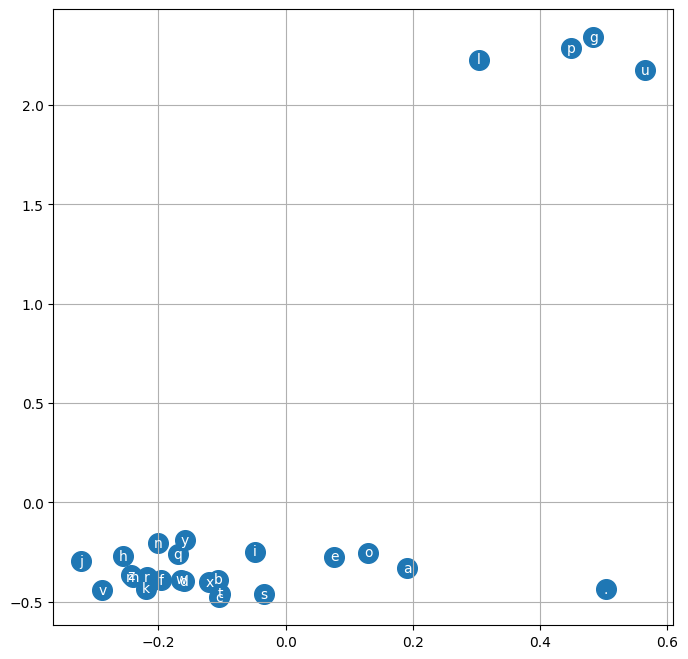

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')
C.shape

In [26]:
def initalize_network():
    global C, W1, b1, W2, b2, params
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 10), generator=g)
    W1 = torch.randn((30, 200), generator=g)
    b1 = torch.randn((200), generator=g)
    W2 = torch.randn((200, 27), generator=g)
    b2 = torch.randn((27), generator=g)
    params = [C, W1, b1, W2, b2]
    for p in params:
        p.requires_grad_()
    print(sum(p.nelement() for p in params), 'parameters')
   
initalize_network()
    
def forward(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

def train(X, Y, batchsize=32, iter=10):
    # removed the initialization from here to avoid reinitializing the network
    for i in range(iter):
        # minibatch construction
        ix = torch.randint(0, X.shape[0], (batchsize,))
        
        loss = forward(X[ix], Y[ix])
        backward(loss, lr=0.1)
        

X, Y = build_dataset(words)
train(X, Y, batchsize=32, iter=10)

print(forward(X, Y))

11897 parameters
tensor(17.7389, grad_fn=<NllLossBackward0>)


In [27]:
train(Xtr, Ytr, batchsize=32, iter=50000)
    
for data, desc in zip([(Xtr, Ytr), (Xvl, Yvl), (Xte, Yte)], ['train', 'validation', 'test']):
    print(f"{desc} loss:", forward(data[0], data[1]).item())

train loss: 2.3075132369995117
validation loss: 2.3362033367156982
test loss: 2.328051805496216


In [28]:
# Sampling from the model

block_size = 3
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        idx = torch.multinomial(prob, num_samples=1).item()
        context = context[1:] + [idx]
        if idx == 0:
            break
        out.append(idx)
        
        
    print(''.join(itos[i] for i in out))
        

zia
sarish
susne
dibra
kuyson
kwi
mida
anncoriegone
ajaneyminesia
sine
isa
marka
quin
stephariyean
keyter
aya
nisay
linell
menia
nornee
